In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pandas.plotting import scatter_matrix
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf
import numpy as np
from scipy.stats import pearsonr
from scipy import stats
from scipy.stats.mstats import winsorize
from scipy.stats import shapiro
from scipy.stats import f_oneway

### Analyzing the Immowelt.de Data

#### loading the data

In [2]:
filename = "scraping_data.h5"
hdf = pd.HDFStore(filename, mode="r")
keys = hdf.keys()
filtered_keys = [key for key in keys if "/df_immowelt_2023" in key]
filtered_keys = filtered_keys[::-1]


In [3]:
immo_dict = {}
for key in filtered_keys:
    immo_dict[key] = hdf.get(key)

#### preparing the data

In [4]:
average_rent_list = []
for key, value in immo_dict.items():
    average_rent = immo_dict[key].Rent.sum() / len(immo_dict[key])
    average_rent_list.append(average_rent)


In [5]:
data_average_rent = pd.DataFrame(
    {"Day": range(1, len(average_rent_list) + 1), "Average_Rent": average_rent_list}
)

In [6]:
df_names = []
for key in immo_dict.keys():
    temp_df = immo_dict[key]
    temp_df["date"] = key.split("/")[2]
    df_names.append(temp_df)

immo_welt_concat_date = pd.concat(df_names)
immo_welt_concat_date.reset_index(inplace=True)
immo_welt_concat_int = immo_welt_concat_date

In [7]:
date_to_value = {
    "2023-05-23": 1,
    "2023-05-24": 2,
    "2023-05-25": 3,
    "2023-05-26": 4,
    "2023-05-27": 5,
    "2023-05-28": 6,
    "2023-05-29": 7,
}

# Replace the dates with corresponding values
immo_welt_concat_int["date"].replace(date_to_value, inplace=True)

### Plotting the regression and the scatterplot
#### Average rent per flat in Munich between May 23, 2023 and May 29, 2023. 

(next step would be a time series analysis, but for seven days I ommit it here)


In [8]:
immo_welt_concat_int["Rent_sqrt"] = np.sqrt(immo_welt_concat_int["Rent"])
immo_welt_concat_int["Rent_box"], lambda_value = stats.boxcox(
    immo_welt_concat_int["Rent"]
)
immo_welt_concat_int["Rent_winsor"] = winsorize(
    immo_welt_concat_int["Rent"], limits=[0.1, 0.1]
)
immo_welt_concat_int["Rent_winsor_log"] = np.log(immo_welt_concat_int["Rent"])
immo_welt_concat_int["Rent_sqrt_sqrt"] = np.sqrt(immo_welt_concat_int["Rent"])

In [9]:
for column in immo_welt_concat_int.iloc[:, 6:]:
    model_formula = f"{column} ~ date"
    model = smf.ols(formula=model_formula, data=immo_welt_concat_int)
    results = model.fit()

    summary = results.summary()
    prob_omnibus = summary.tables[2].data[0][1]
    prob = summary.tables[2].data[1][1]
    print(model_formula, prob_omnibus, prob)

Rent_sqrt ~ date 634.783  0.000
Rent_box ~ date 62.234  0.000
Rent_winsor ~ date 764.425  0.000
Rent_winsor_log ~ date 60.916  0.000
Rent_sqrt_sqrt ~ date 634.783  0.000


                            OLS Regression Results                            
Dep. Variable:                   Rent   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3011
Date:                Fri, 02 Jun 2023   Prob (F-statistic):              0.583
Time:                        12:15:54   Log-Likelihood:                -33874.
No. Observations:                4116   AIC:                         6.775e+04
Df Residuals:                    4114   BIC:                         6.776e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1900.7508     31.633     60.088      0.0

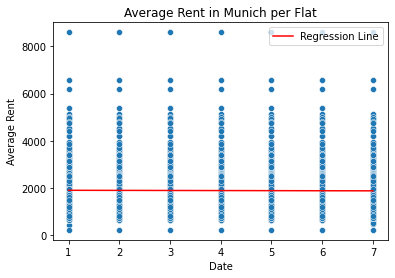

In [10]:
model = smf.ols("Rent ~ date", immo_welt_concat_int)
results = model.fit()

print(results.summary())


intercept = results.params[0]
slope = results.params[1]

x = np.linspace(
    immo_welt_concat_int["date"].min(), immo_welt_concat_int["date"].max(), 100
)
y = results.params[0] + results.params[1] * x
plt.plot(x, y, color="red", label="Regression Line")
sns.scatterplot(x=immo_welt_concat_int.date, y=immo_welt_concat_int.Rent)
dates = pd.date_range(start="2023-05-23", end="2023-05-29", freq="D")
date_labels = [date.date() for date in dates]


plt.title("Average Rent in Munich per Flat")
plt.xlabel("Date")
plt.ylabel("Average Rent")
plt.show()

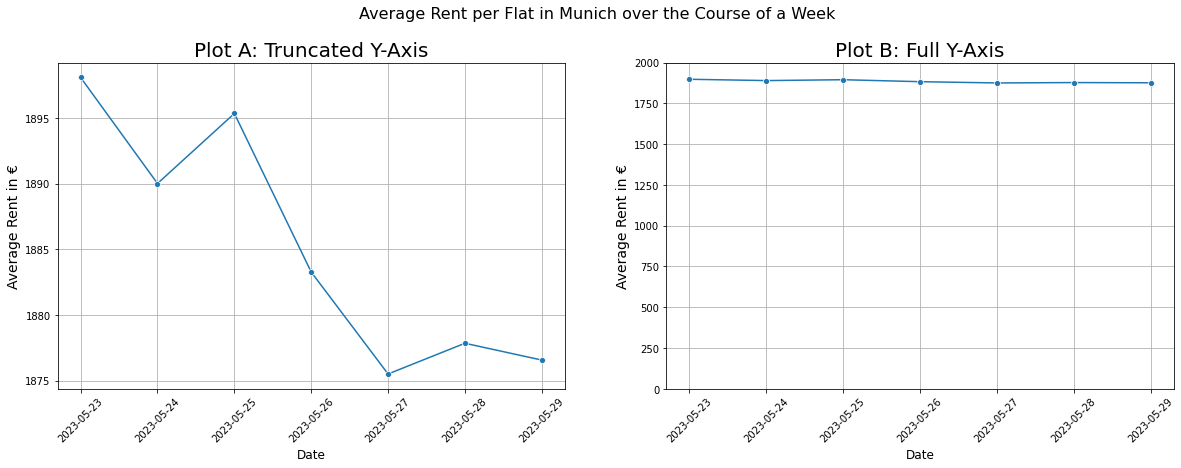

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    x=data_average_rent.Day,
    y=data_average_rent.Average_Rent,
    linestyle="-",
    marker="o",
    ax=ax1,
)
dates = pd.date_range(start="2023-05-23", end="2023-05-29", freq="D")
date_labels = [date.date() for date in dates]
ax1.set_xticks(data_average_rent.Day)
ax1.set_xticklabels(date_labels, rotation=45)
ax1.set_title("Plot A: Truncated Y-Axis", fontsize=20)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Average Rent in €", fontsize=14)
ax1.grid(True)

sns.lineplot(
    x=data_average_rent.Day,
    y=data_average_rent.Average_Rent,
    linestyle="-",
    marker="o",
    ax=ax2,
)
ax2.set_xticks(data_average_rent.Day)
ax2.set_xticklabels(date_labels, rotation=45)
ax2.set_title("Plot B: Full Y-Axis", fontsize=20)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Average Rent in €", fontsize=14)
ax2.set_ylim(0, 2000)
ax2.grid(True)

fig.suptitle(
    "Average Rent per Flat in Munich over the Course of a Week", fontsize=16, y=1.01
)

plt.show()

### Calculationg the Average Rent per SQM

In [39]:
immo_welt_concat_int["Rent_per_Sqm"] = (
    immo_welt_concat_int.Rent / immo_welt_concat_int.SQM
)

print(
    f"The average SQM rent per flat in Munich is {immo_welt_concat_int['Rent_per_Sqm'].sum() / len(immo_welt_concat_int)}€"
)
print(
    f"This is an increase of {(immo_welt_concat_int['Rent_per_Sqm'].sum() / len(immo_welt_concat_int)) / 14.58 - 1 } percent"
)
print(
    f"The Average per SQM in Munich is {immo_welt_concat_int.Rent.sum() / immo_welt_concat_int.SQM.sum()}"
)

The average SQM rent per flat in Munich is 26.37956279832419€
This is an increase of 0.8092978599673657 percent
The Average per SQM in Munich is 24.394059622515503


### Calculating an Anova

<Figure size 864x432 with 0 Axes>

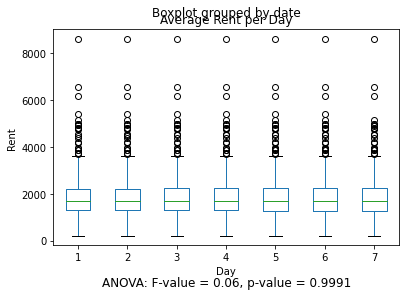

ANOVA: F-value = 0.06, p-value = 0.9991


In [15]:


group1_rent = immo_welt_concat_int.loc[immo_welt_concat_int["date"] == 1, "Rent"]
group2_rent = immo_welt_concat_int.loc[immo_welt_concat_int["date"] == 2, "Rent"]
group3_rent = immo_welt_concat_int.loc[immo_welt_concat_int["date"] == 3, "Rent"]
group4_rent = immo_welt_concat_int.loc[immo_welt_concat_int["date"] == 4, "Rent"]
group5_rent = immo_welt_concat_int.loc[immo_welt_concat_int["date"] == 5, "Rent"]
group6_rent = immo_welt_concat_int.loc[immo_welt_concat_int["date"] == 6, "Rent"]
group7_rent = immo_welt_concat_int.loc[immo_welt_concat_int["date"] == 7, "Rent"]


f_value, p_value = f_oneway(
    group1_rent,
    group2_rent,
    group3_rent,
    group4_rent,
    group5_rent,
    group6_rent,
    group7_rent,
)

plt.figure(figsize=(12, 6))
immo_welt_concat_int.boxplot(column="Rent", by="date", grid=False)
plt.title("Average Rent per Day")
plt.ylabel("Rent")
plt.xlabel("Day")


summary = f"ANOVA: F-value = {f_value:.2f}, p-value = {p_value:.4f}"
plt.figtext(0.5, 0.01, summary, ha="center", fontsize=12)

plt.show()
print(summary)

This tells us, that all the rents from all days come from the same population. In other words, there are no fluctuations nor a trend.

# Analyzing booking.com data

#### loading the data

In [16]:
keys = hdf.keys()
filtered_keys = [key for key in keys if "df_booking" in key]
filtered_keys = filtered_keys[::-1]


In [18]:
booking_dict = {}
for key in filtered_keys:
    booking_dict[key] = hdf.get(key)

In [19]:
for key in booking_dict:
    booking_dict[key]["price"] = booking_dict[key].apply(
        lambda row: row["Discounted"]
        if row["Discounted"] != -1
        else row["Undiscounted"],
        axis=1,
    )

In [20]:
average_hotel_price_list = []
for key, value in booking_dict.items():
    average_hote_price = booking_dict[key].price.sum() / len(booking_dict[key])
    average_hotel_price_list.append(average_hote_price)


In [21]:
data_average_room_price = pd.DataFrame(
    {
        "Day": range(1, len(average_hotel_price_list) + 1),
        "Average_room_price": average_hotel_price_list,
    }
)

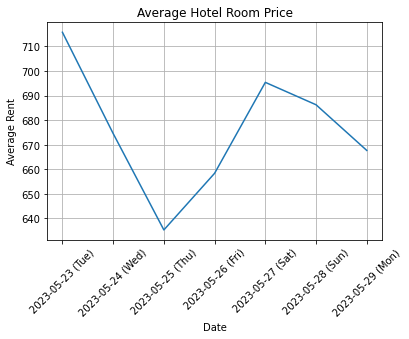

In [22]:
sns.lineplot(
    x=data_average_room_price.Day, y=data_average_room_price.Average_room_price
)
dates = pd.date_range(start="2023-05-23", end="2023-05-29", freq="D")
dates_with_weekday = dates.strftime("%Y-%m-%d (%a)")
date_labels = [date.date() for date in dates]
plt.xticks(data_average_room_price.Day, dates_with_weekday)
plt.xticks(rotation=45)
plt.grid(True)

plt.title("Average Hotel Room Price")
plt.xlabel("Date")
plt.ylabel("Average Rent")
plt.show()

In [23]:
df_names = []
for key in booking_dict.keys():
    temp_df = booking_dict[key]
    temp_df["date"] = key.split("/")[2]
    df_names.append(temp_df)

booking_dict_concat_date = pd.concat(df_names)
booking_dict_concat_date.reset_index(inplace=True)
booking_dict_concat_int = booking_dict_concat_date

In [24]:
date_to_value = {
    "2023-05-23": 1,
    "2023-05-24": 2,
    "2023-05-25": 3,
    "2023-05-26": 4,
    "2023-05-27": 5,
    "2023-05-28": 6,
    "2023-05-29": 7,
}

# Replace the dates with corresponding values
booking_dict_concat_int["date"].replace(date_to_value, inplace=True)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.256
Date:                Fri, 02 Jun 2023   Prob (F-statistic):              0.263
Time:                        12:15:55   Log-Likelihood:                -19551.
No. Observations:                2896   AIC:                         3.911e+04
Df Residuals:                    2894   BIC:                         3.912e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    684.8575      8.595     79.677      0.0

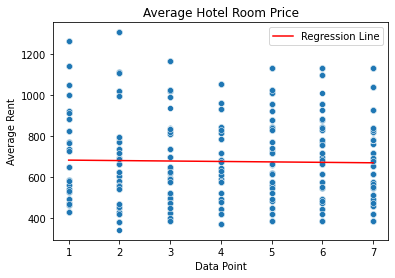

In [25]:
model = smf.ols("price ~ date", booking_dict_concat_int)
results = model.fit()

print(results.summary())


intercept = results.params[0]
slope = results.params[1]

x = np.linspace(
    booking_dict_concat_int["date"].min(), booking_dict_concat_int["date"].max(), 100
)
y = results.params[0] + results.params[1] * x
plt.plot(x, y, color="red", label="Regression Line")

sns.scatterplot(x=booking_dict_concat_int.date, y=booking_dict_concat_int.price)
dates = pd.date_range(start="2023-05-23", end="2023-05-29", freq="D")
date_labels = [date.date() for date in dates]
# plt.xticks(booking_dict_concat_int.date, date_labels)
# plt.xticks(rotation=45)


plt.title("Average Hotel Room Price")
plt.xlabel("Data Point")
plt.ylabel("Average Rent")
plt.show()

### Calculating an Anova

<Figure size 864x432 with 0 Axes>

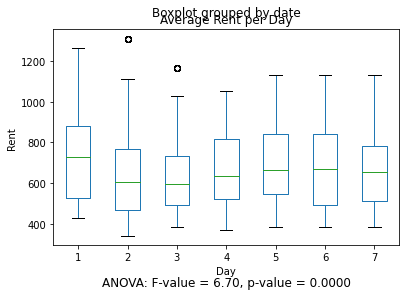

ANOVA: F-value = 6.70, p-value = 0.0000


In [26]:
group1_price = booking_dict_concat_int.loc[
    booking_dict_concat_int["date"] == 1, "price"
]
group2_price = booking_dict_concat_int.loc[
    booking_dict_concat_int["date"] == 2, "price"
]
group3_price = booking_dict_concat_int.loc[
    booking_dict_concat_int["date"] == 3, "price"
]
group4_price = booking_dict_concat_int.loc[
    booking_dict_concat_int["date"] == 4, "price"
]
group5_price = booking_dict_concat_int.loc[
    booking_dict_concat_int["date"] == 5, "price"
]
group6_price = booking_dict_concat_int.loc[
    booking_dict_concat_int["date"] == 6, "price"
]
group7_price = booking_dict_concat_int.loc[
    booking_dict_concat_int["date"] == 7, "price"
]


f_value, p_value = f_oneway(
    group1_price,
    group2_price,
    group3_price,
    group4_price,
    group5_price,
    group6_price,
    group7_price,
)


plt.figure(figsize=(12, 6))
booking_dict_concat_int.boxplot(column="price", by="date", grid=False)
plt.title("Average Rent per Day")
plt.ylabel("Rent")
plt.xlabel("Day")

summary = f"ANOVA: F-value = {f_value:.2f}, p-value = {p_value:.4f}"
plt.figtext(0.5, 0.01, summary, ha="center", fontsize=12)

plt.show()
print(summary)

# Boerse.de

In [28]:
keys = hdf.keys()
filtered_keys = [key for key in keys if "df_boerse" in key]
filtered_keys = filtered_keys[::-1]


In [30]:
boerse_dict = {}
for key in filtered_keys:
    boerse_dict[key] = hdf.get(key)

In [31]:
combined_df = boerse_dict["/boerse/2023-05-23/df_boerse_2023-05-23"]
combined_df = combined_df.rename(columns={"Price": "2023-05-23"})

for key in filtered_keys[1:]:
    df = boerse_dict[key]
    date = key.split("/")[2]

    df = df.rename(columns={"Price": date})

    combined_df = pd.merge(combined_df, df[["Name", date]], on="Name", how="left")

combined_df

,Name,2023-05-23,2023-05-24,2023-05-25,2023-05-26,2023-05-27,2023-05-28,2023-05-29
0,vonovia,18.62,18.15,17.73,17.50,17.53,17.53,17.40
1,deutsche_wohnen,20.07,19.46,19.04,19.23,19.25,19.25,18.69
2,leg,53.83,52.31,50.02,49.86,49.61,49.61,48.20
3,grand_city,7.67,7.25,6.95,7.02,7.02,7.02,6.92


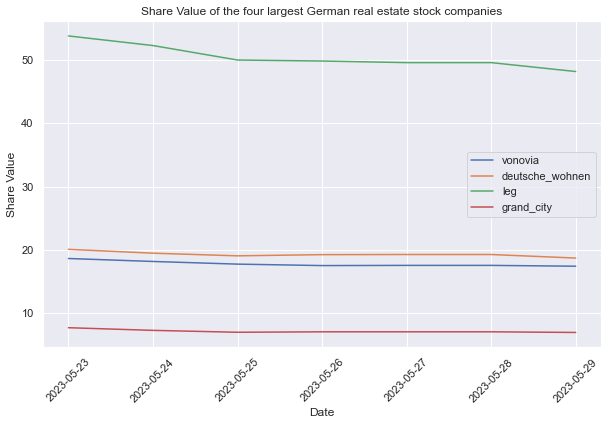

In [44]:
melted_df = combined_df.melt(id_vars='Name', var_name='Date', value_name='Value')


sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))
sns.lineplot(data=melted_df, x='Date', y='Value', hue='Name')


plt.title('Share Value of the four largest German real estate stock companies')
plt.xlabel('Date')
plt.ylabel('Share Value')
plt.xticks(rotation=45)
plt.legend(loc='best')  

plt.show()


In [32]:
df = combined_df.transpose()
df = df.rename(columns=df.iloc[0]).drop(df.index[0])


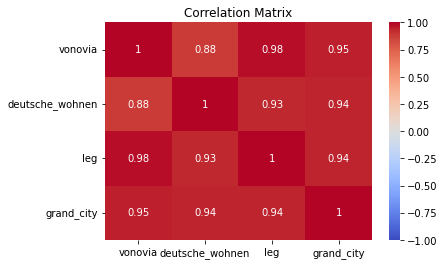

In [33]:
correlation_matrix = df.corr()

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")

plt.show()